In [1]:
import githistoryvis as ghv

### Gather the data

Githistoryvis exposes the class `git_history`.

The inizialization:

```python
foo = git_history(PATH)
```
sets the attribute `foo.path` that point to the git respository in PATH.

Also `def_states` (and `def_states_explain`) are defined at inizialitation.
They are used to transform the state in the dataframe to number for visualization and define the legend.

You can overwrite them at your own risk.

```python
def_states = {
    'A' : 120.,
    'M' : 180.,
    'S' : 255., # custom value, Static
    'D' : 240.,
    'N' : 128., # custom value, Non existent
}

def_states_explain = {
    'A' : 'Added',
    'D' : 'Deleted',
    'M' : 'Modified',
    'S' : 'Static',
    'N' : 'Non existent'
}
```


The method

```python
foo.get_history()
```
extracts the git log, and define:

- foo.all_commits = the whole git log
- foo.commits     = the commits SHA-1
- foo.all_files   = all the unique file ever existed



In [33]:
import os

path =  os.getcwd() # put here the desired git repo path

gt = ghv.git_history(path)

gt.get_history()

### Visualize the data

We define a pandas DataFrame to contain all the files (Rows) and the status (Columns).

This Grid represent the status of each file at each step or commit.

The inizial stata for all the files is `N` or `Non existent`, they are updated in the sequential reding of `git_history.all_commits` object.

## Deserialize and structure the data

The data gather in `githistoryvis.git_history` object are deserialized and gathered in a pandas DataFrame.

In [7]:
import pandas as pd
import numpy as np

In [8]:
def data_structure(git_history_object):
    
    all_filenames = pd.DataFrame(pd.DataFrame(list(git_history_object.all_files)),columns=git_history_object.commits, index=git_history_object.all_files)

    # fill NaN
    all_filenames.fillna('N', inplace=True)

    actual_commit = 0
    # previous_commit = 0
    for i in git_history_object.all_commits:
        # set the commit number
        if i[0] == 'C':
            value = i[1]
            # starting at the second commit see which file exist in the previous commit
            if actual_commit != int(all_filenames.columns[0]):
                 previous_commit = actual_commit
            actual_commit = value
            # assig 1 to file not null un the previous commit
            if previous_commit != 0:
                all_filenames[actual_commit][
                    (all_filenames[previous_commit] != 'N') & (all_filenames[previous_commit] != 'D')] = 'S'
    #             all_filenames[previous_commit][all_filenames[actual_commit] == 'D'] = 'D'
    #             all_filenames[actual_commit][all_filenames[actual_commit] == 'D']   = 'N'
    #         print previous_commit,'>',actual_commit
        else:
            state,value = i
    #         print ' '*4,'-',state,value
            all_filenames.ix[value,actual_commit] = state
    return all_filenames

In [9]:
all_filenames = data_structure(gt)

## Visualize the data

The data from the pandas DataFrame coul be visualized by this simple example routine.

The arguments are:

- size (default 200) : the size of the pyplot.scatteplot.
- figsize (default [9,7]) : size of the pyplot.figure.
- linewidths (default 3) : width of the pyplot.scatteplot outer lines.
- outpath : if defined, the figure will be saved without visualization.

In [10]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [38]:
def plot_history_df(plot_df,**kwargs):

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = 500
        
    if 'figsize' in kwargs:
        figsize = kwargs['figsize']
    else:
        figsize = [10,12]
        
    if 'linewidths' in kwargs:
        linewidths = kwargs['linewidths']
    else:
        linewidths = 3
        
    h = plot_df.applymap(lambda x: gt.def_states[x]).values.copy()
    h[h == 128] = np.nan

    fig = plt.figure(figsize=figsize)

    ax = plt.subplot(111)
    for i in range(len(plot_df.index)):
        x = range(len(plot_df.columns))
        y = [i for kk in x]
        ax.scatter(x, y, s = size, c=h[i,:], alpha=1, marker='o',linewidths = linewidths , cmap = plt.cm.spectral,vmin = 0, vmax = 255)
        ax.plot(x, y, lw = 3, c='k', zorder=0)

    ax.set_xticks(range(h.shape[1]))
    ax.set_xticklabels(plot_df.columns,rotation=90)

    ax.set_xlabel('commits sha-1 (time arrow to the right ->)')
    ax.set_xlim([-.5,len(plot_df.columns)-0.5])
    ax.set_ylabel('file names')
    ax.set_yticks(range(h.shape[0]))
    ax.set_yticklabels(plot_df.index.tolist())
    ax.set_yticks = 0.1
    # set 0 to bounding box width
    [i.set_linewidth(0.0) for i in ax.spines.itervalues()]
    # see http://stackoverflow.com/a/20416681/1435167
    # erase x ticks
    for tic in ax.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    #     tic.label1On = tic.label2On = False
    # erase y ticks
    for tic in ax.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    #     tic.label1On = tic.label2On = False

    ax2 = fig.add_axes([0.25, .9, 0.5, 0.075])

    colors = np.array(gt.def_states.values()).astype('float')
    colors[colors == 128] = np.nan

    x = range(len(colors))
    y = [1 for kk in x]
    ax2.scatter(x, y, s = size, c=colors, alpha=1, marker='o',linewidths = 3, cmap = plt.cm.spectral,vmin = 0, vmax = 255)
    ax2.plot(x, y, lw = 3, c='k', zorder=0)

    ax2.set_xticks(x)
    ax2.set_xticklabels(gt.def_states_explain.values())
    ax2.set_xlabel('Legend')
    ax2.set_xlim([-.5,len(x)-0.5])
    ax2.set_ylim([0.99,1.01])
    # set 0 to bounding box width
    [i.set_linewidth(0.0) for i in ax2.spines.itervalues()]
    # # see http://stackoverflow.com/a/20416681/1435167
    # erase x ticks
    for tic in ax2.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    # erase y ticks
    for tic in ax2.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
        tic.label1On = tic.label2On = False

    if 'outpath' in kwargs:
#         print 'Saving figure in '+kwargs['outpath']
        fig.savefig(kwargs['outpath'])
        plt.close()

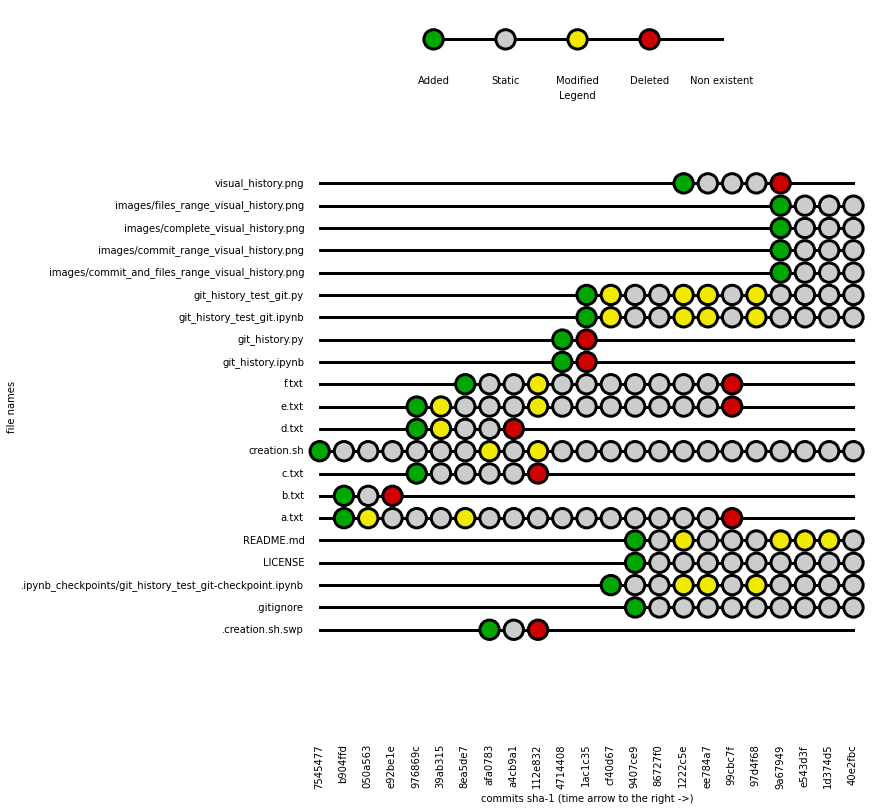

In [49]:
all_filenames
plot_history_df(all_filenames,size= 375)
plot_history_df(all_filenames,size= 375,outpath=path+os.sep+'images/complete_visual_history.png')

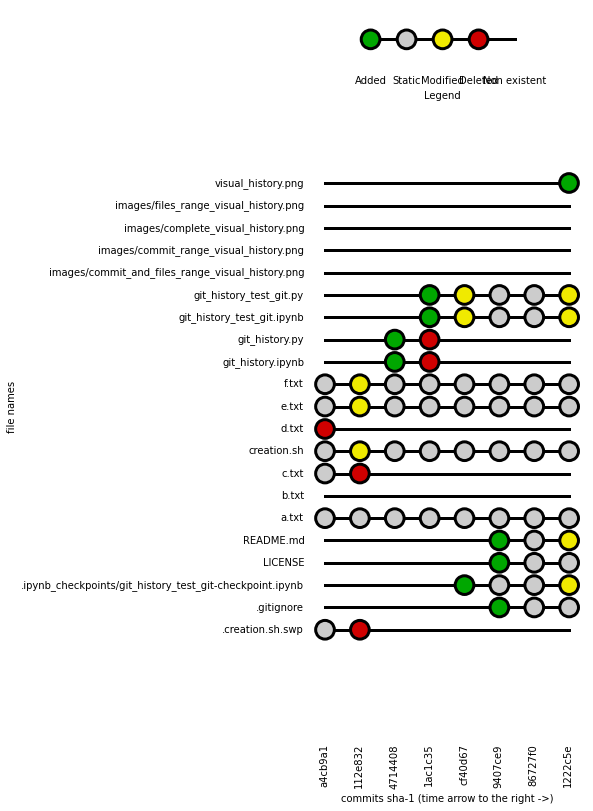

In [66]:
# filtering the history on:
# a commit range
plot_df_commit_range = all_filenames.ix[:,'a4cb9a1':'1222c5e']
plot_df_commit_range
plot_history_df(plot_df_commit_range,size= 350, figsize= [5,12])
plot_history_df(plot_df_commit_range,size= 350, figsize= [5,12], outpath=path+os.sep+'images/commit_range.png')

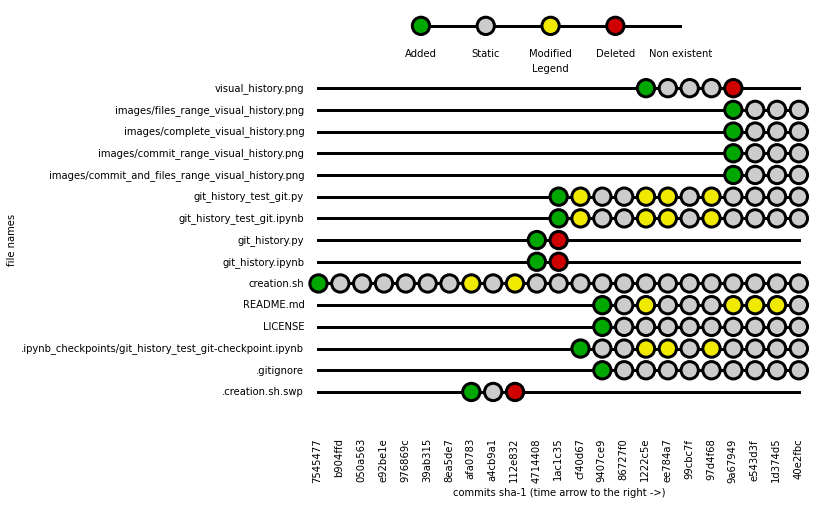

In [47]:
# filtering the history on:
# a file range: all files not ending with txt
plot_df_file_range = all_filenames[~all_filenames.index.str.contains('txt$')]
plot_history_df(plot_df_file_range,size= 300, figsize= [9,7])
plot_history_df(plot_df_file_range,size= 300, figsize= [9,7], outpath=path+os.sep+'images/file_range.png')

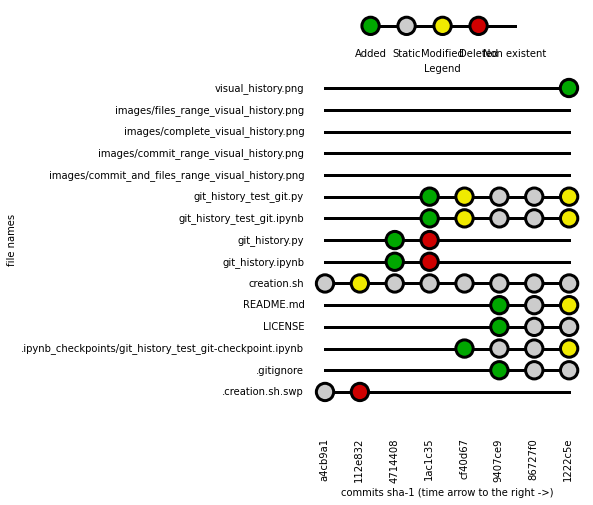

In [69]:
# filtering the history on:
# a commit range AND a file range: all files not ending with txt
plot_df_commit_file_range = all_filenames.ix[:,'a4cb9a1':'1222c5e'][~all_filenames.index.str.contains('txt$')]
plot_history_df(plot_df_commit_file_range,size= 300,figsize= [5,7])
plot_history_df(plot_df_commit_file_range,size= 300,figsize= [5,7],outpath=path+os.sep+'images/commit_file_range.png')

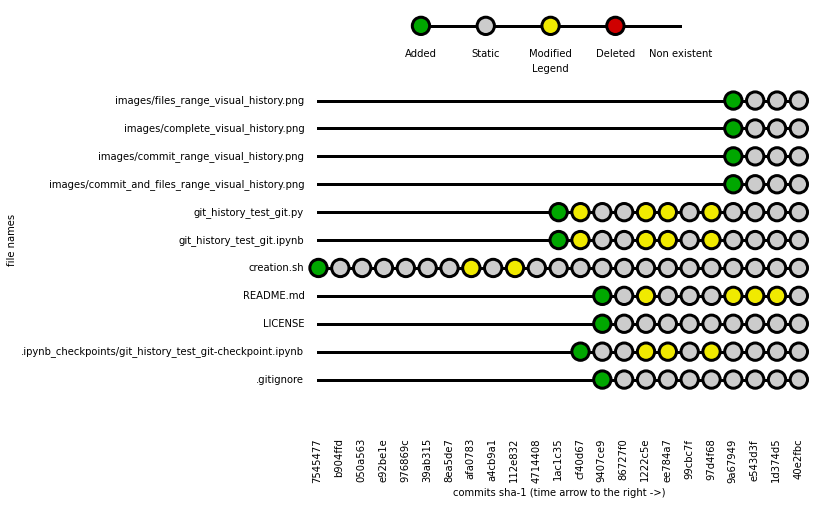

In [54]:
# filtering the history on:
# a commit range AND a file range: all files not ending with txt
plot_df_state_filter = all_filenames[all_filenames[all_filenames.columns[-1]] != 'N']
plot_history_df(plot_df_state_filter,size= 300,figsize= [9,7])
plot_history_df(plot_df_state_filter,size= 300,figsize= [9,7],outpath=path+os.sep+'images/state_filter.png')